# Import Necessary libraries

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

## Data Preparation

In [3]:
# seeing the data from the filtered excell
Stroked_data = pd.read_csv('resampled_data.csv')
Stroked_data.drop(columns=['Unnamed: 0'],inplace=True)
Stroked_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,bmi,smoking_status,stroke,AgeGroup,GlucoseLevelRange,BMIGroup
0,Male,67.0,0,1,Yes,Private,Urban,36.60000,formerly smoked,1,60-80,200-250,Obese
1,Female,61.0,0,0,Yes,Self-employed,Rural,28.89456,never smoked,1,60-80,200-250,Overweight
2,Male,80.0,0,1,Yes,Private,Rural,32.50000,never smoked,1,80+,100-150,Obese
3,Female,49.0,0,0,Yes,Private,Urban,34.40000,smokes,1,40-60,150-200,Obese
4,Female,79.0,1,0,Yes,Self-employed,Rural,24.00000,never smoked,1,60-80,150-200,Normal


In [4]:
Stroked_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   bmi                5109 non-null   float64
 8   smoking_status     5109 non-null   object 
 9   stroke             5109 non-null   int64  
 10  AgeGroup           5109 non-null   object 
 11  GlucoseLevelRange  5109 non-null   object 
 12  BMIGroup           5109 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 519.0+ KB


In [5]:
Variables = ['ever_married']
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})
Stroked_data[Variables] = Stroked_data[Variables].apply(binary_map)

The binary_map() function is used to convert the categorical values of the 'ever_married' column in the data to binary values. Specifically, the function maps the value 'Yes' to 1 and the value 'No' to 0.

In [6]:
dummy_Variables = pd.get_dummies(Stroked_data[['gender', 'work_type', 'Residence_type', 'smoking_status', 'AgeGroup', 'GlucoseLevelRange', 'BMIGroup']], drop_first=True)
dummy_Variables.head()

,gender_Male,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,AgeGroup_20-40,...,AgeGroup_60-80,AgeGroup_80+,GlucoseLevelRange_150-200,GlucoseLevelRange_200-250,GlucoseLevelRange_250+,GlucoseLevelRange_< 100,BMIGroup_Normal,BMIGroup_Obese,BMIGroup_Overweight,BMIGroup_Underweight
0,1,0,1,0,0,1,1,0,0,0,...,1,0,0,1,0,0,0,1,0,0
1,0,0,0,1,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0
2,1,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0


It takes as input a DataFrame, containing dummy variables for all categorical variables of 'gender', 'work_type', 'Residence_type', 'smoking_status', 'AgeGroup', 'GlucoseLevelRange', 'BMIGroup'

In [7]:
Stroked_data = pd.concat([Stroked_data, dummy_Variables], axis=1)
Stroked_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,bmi,smoking_status,stroke,...,AgeGroup_60-80,AgeGroup_80+,GlucoseLevelRange_150-200,GlucoseLevelRange_200-250,GlucoseLevelRange_250+,GlucoseLevelRange_< 100,BMIGroup_Normal,BMIGroup_Obese,BMIGroup_Overweight,BMIGroup_Underweight
0,Male,67.0,0,1,1,Private,Urban,36.60000,formerly smoked,1,...,1,0,0,1,0,0,0,1,0,0
1,Female,61.0,0,0,1,Self-employed,Rural,28.89456,never smoked,1,...,1,0,0,1,0,0,0,0,1,0
2,Male,80.0,0,1,1,Private,Rural,32.50000,never smoked,1,...,0,1,0,0,0,0,0,1,0,0
3,Female,49.0,0,0,1,Private,Urban,34.40000,smokes,1,...,0,0,1,0,0,0,0,1,0,0
4,Female,79.0,1,0,1,Self-employed,Rural,24.00000,never smoked,1,...,1,0,1,0,0,0,1,0,0,0


In [8]:
stroked = Stroked_data.copy()
stroked = stroked.drop(['gender', 'work_type', 'Residence_type', 'smoking_status', 'AgeGroup', 'GlucoseLevelRange', 'BMIGroup'], axis=1)
stroked.head()

,age,hypertension,heart_disease,ever_married,bmi,stroke,gender_Male,work_type_Never_worked,work_type_Private,work_type_Self-employed,...,AgeGroup_60-80,AgeGroup_80+,GlucoseLevelRange_150-200,GlucoseLevelRange_200-250,GlucoseLevelRange_250+,GlucoseLevelRange_< 100,BMIGroup_Normal,BMIGroup_Obese,BMIGroup_Overweight,BMIGroup_Underweight
0,67.0,0,1,1,36.60000,1,1,0,1,0,...,1,0,0,1,0,0,0,1,0,0
1,61.0,0,0,1,28.89456,1,0,0,0,1,...,1,0,0,1,0,0,0,0,1,0
2,80.0,0,1,1,32.50000,1,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
3,49.0,0,0,1,34.40000,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
4,79.0,1,0,1,24.00000,1,0,0,0,1,...,1,0,1,0,0,0,1,0,0,0


In [9]:
stroked.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5109 non-null   float64
 1   hypertension                    5109 non-null   int64  
 2   heart_disease                   5109 non-null   int64  
 3   ever_married                    5109 non-null   int64  
 4   bmi                             5109 non-null   float64
 5   stroke                          5109 non-null   int64  
 6   gender_Male                     5109 non-null   uint8  
 7   work_type_Never_worked          5109 non-null   uint8  
 8   work_type_Private               5109 non-null   uint8  
 9   work_type_Self-employed         5109 non-null   uint8  
 10  work_type_children              5109 non-null   uint8  
 11  Residence_type_Urban            5109 non-null   uint8  
 12  smoking_status_formerly smoked  51

## Test-Train-Split

In [10]:
X = stroked.drop(['stroke'], axis=1)
y = stroked['stroke']
X.head()

,age,hypertension,heart_disease,ever_married,bmi,gender_Male,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,...,AgeGroup_60-80,AgeGroup_80+,GlucoseLevelRange_150-200,GlucoseLevelRange_200-250,GlucoseLevelRange_250+,GlucoseLevelRange_< 100,BMIGroup_Normal,BMIGroup_Obese,BMIGroup_Overweight,BMIGroup_Underweight
0,67.0,0,1,1,36.60000,1,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
1,61.0,0,0,1,28.89456,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
2,80.0,0,1,1,32.50000,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
3,49.0,0,0,1,34.40000,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
4,79.0,1,0,1,24.00000,0,0,0,1,0,...,1,0,1,0,0,0,1,0,0,0


In [11]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: stroke, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [13]:
stroke_Percentage = (sum(stroked['stroke'])/len(stroked['stroke'].index))*100
stroke_Percentage

4.873752201996477

The percentage of getting stroke from dataset is about 4.9%.

In [14]:
stroked.stroke.value_counts()

0    4860
1     249
Name: stroke, dtype: int64

Thie ratio of people who got no stroke to stroke 4860 to 249.

______________________________________________________________________________________________________

## Reducing the ratio of the data

In [15]:
Random = stroked.sample(random_state=4)
yes = stroked.loc[stroked['stroke'] == 1]
no = stroked.loc[stroked['stroke'] == 0].sample(n= 1500,random_state= 101)
new_data = pd.concat([yes, no])

In [16]:
new_data.head()

,age,hypertension,heart_disease,ever_married,bmi,stroke,gender_Male,work_type_Never_worked,work_type_Private,work_type_Self-employed,...,AgeGroup_60-80,AgeGroup_80+,GlucoseLevelRange_150-200,GlucoseLevelRange_200-250,GlucoseLevelRange_250+,GlucoseLevelRange_< 100,BMIGroup_Normal,BMIGroup_Obese,BMIGroup_Overweight,BMIGroup_Underweight
0,67.0,0,1,1,36.60000,1,1,0,1,0,...,1,0,0,1,0,0,0,1,0,0
1,61.0,0,0,1,28.89456,1,0,0,0,1,...,1,0,0,1,0,0,0,0,1,0
2,80.0,0,1,1,32.50000,1,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
3,49.0,0,0,1,34.40000,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
4,79.0,1,0,1,24.00000,1,0,0,0,1,...,1,0,1,0,0,0,1,0,0,0


In [17]:
stroke_percentage = (sum(new_data['stroke'])/len(new_data['stroke'].index))*100
stroke_percentage

14.236706689536879

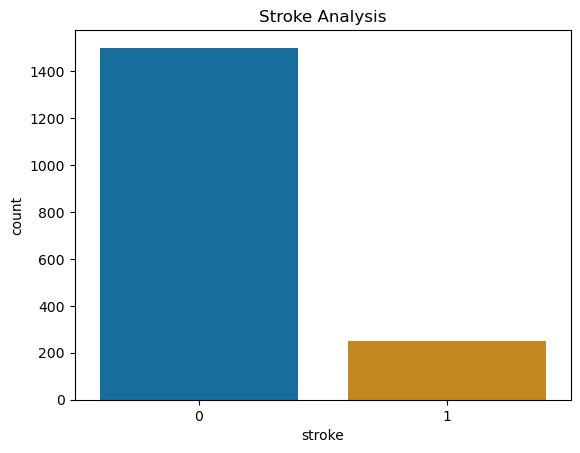

In [18]:
sb.countplot('stroke', data= new_data, palette= "colorblind")
plt.title('Stroke Analysis')
plt.show()

The reduced data size of people with no stroke to 1500 to people with stroke to 249.

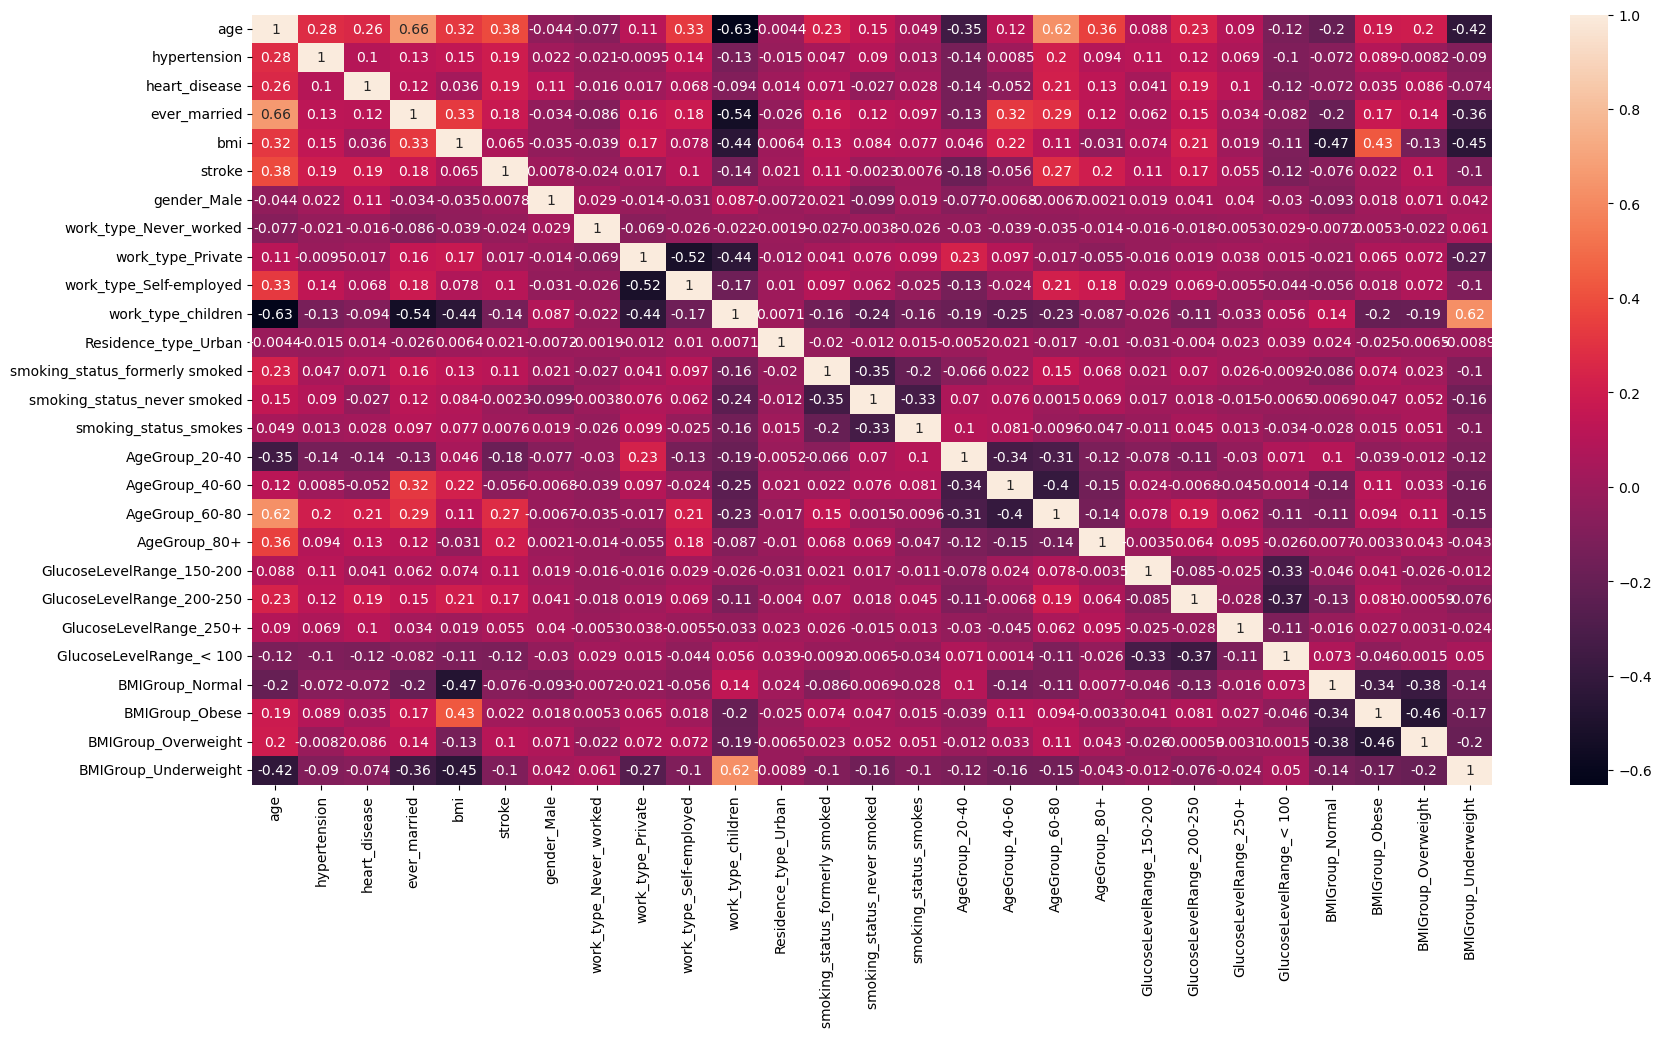

In [19]:
plt.figure(figsize = (20,10))
sb.heatmap(new_data.corr(),annot = True)
plt.show()

In [20]:
new_data.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married', 'bmi', 'stroke',
       'gender_Male', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'AgeGroup_20-40', 'AgeGroup_40-60',
       'AgeGroup_60-80', 'AgeGroup_80+', 'GlucoseLevelRange_150-200',
       'GlucoseLevelRange_200-250', 'GlucoseLevelRange_250+',
       'GlucoseLevelRange_< 100', 'BMIGroup_Normal', 'BMIGroup_Obese',
       'BMIGroup_Overweight', 'BMIGroup_Underweight'],
      dtype='object')

In [21]:
X_test = X_test.drop(['work_type_children','work_type_Private','BMIGroup_Overweight', 'BMIGroup_Normal', 'AgeGroup_20-40', 'smoking_status_never smoked'], axis=1)
X_train = X_train.drop(['work_type_children','work_type_Private','BMIGroup_Overweight', 'BMIGroup_Normal', 'AgeGroup_20-40', 'smoking_status_never smoked'], axis=1)

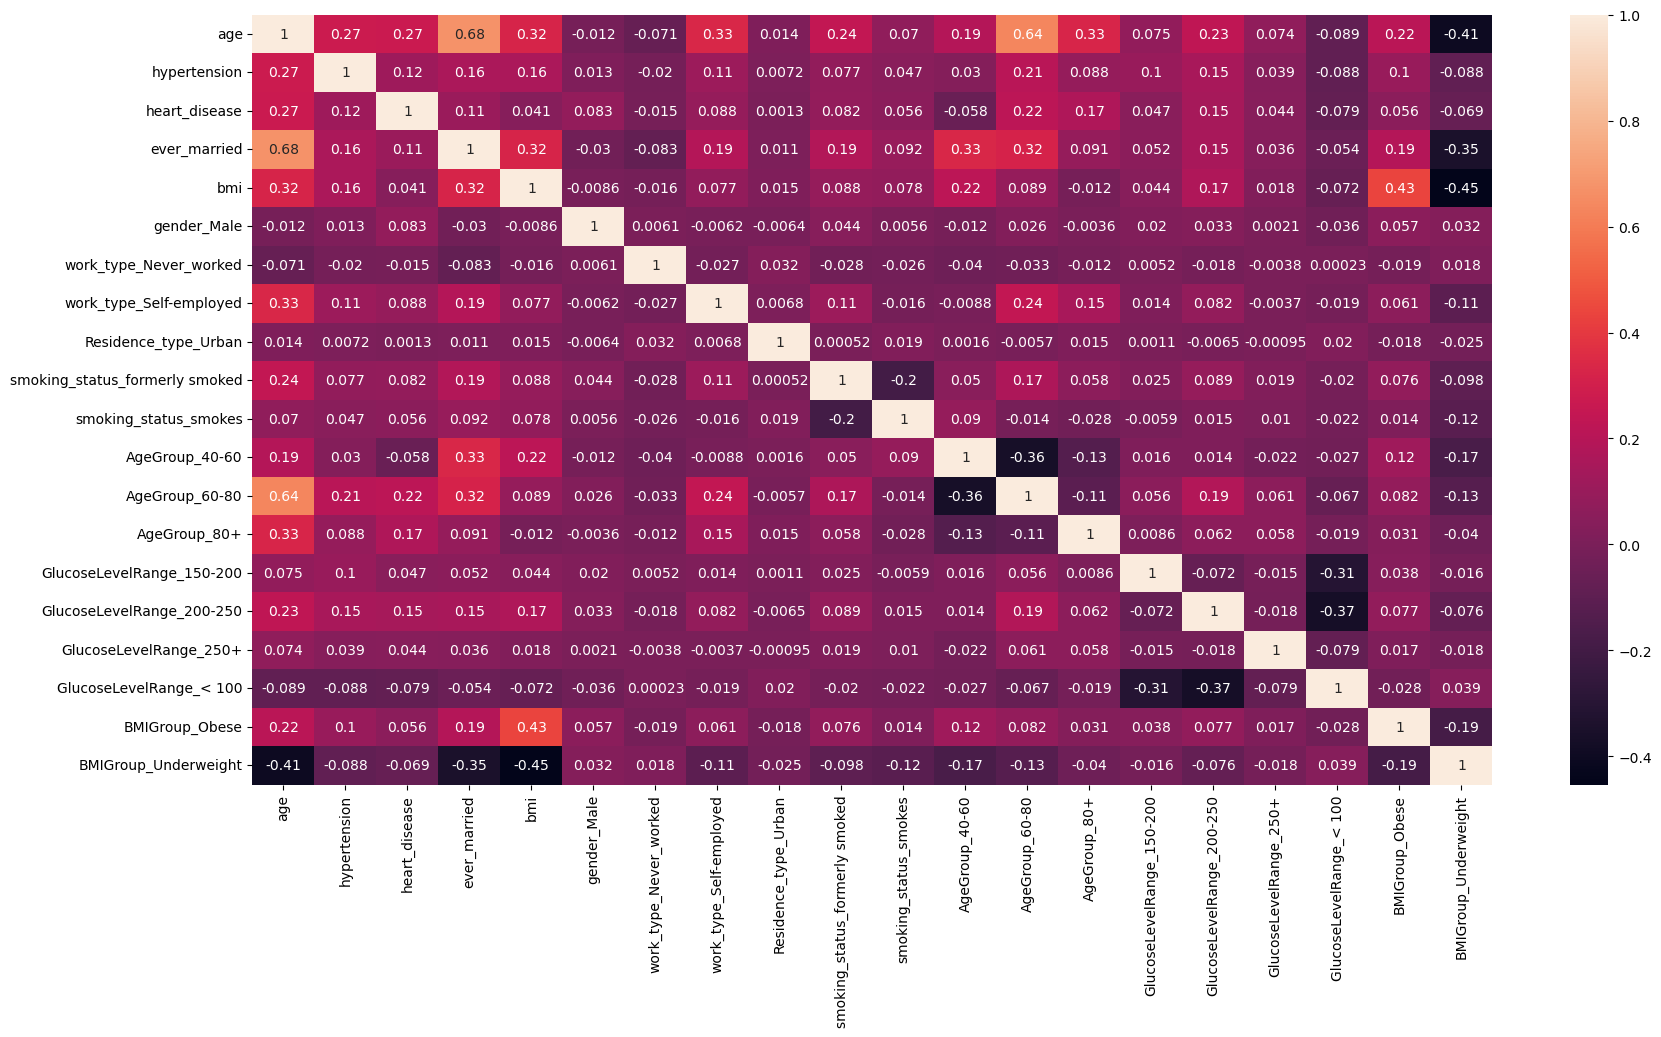

In [22]:
plt.figure(figsize = (20,10))
sb.heatmap(X_train.corr(),annot = True)
plt.show()

_____________________________________________________________________________________________________

## Modal Buliding

In [23]:
logistic_regression = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logistic_regression.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 3576
Model:                            GLM   Df Residuals:                     3555
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -561.70
Date:                Sat, 22 Apr 2023   Deviance:                       1123.4
Time:                        11:33:51   Pearson chi2:                 5.35e+03
No. Iterations:                    21   Pseudo R-squ. (CS):            0.07984
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -8.4075      0.862     -9.754      0.000     -10.097      -6.718
age                                0.0869      0.016      5.568      0.000       0.056       0.118
hypertension                       0.2324      0.199      1.168      0.243      -0.158       0.623
heart_disease                      0.0658      0.236      0.278      0.781      -0.397       0.529
ever_married                      -0.2074      0.265     -0.782      0.434      -0.727       0.312
bmi                                0.0105      0.014      0.740      0.459      -0.017       0.038
gender_Male                       -0.0250      0.166     -0.150      0.880      -0.351       0.301
work_type_Never_worked           -15.8056   1.31e+04     -0.001      0.999   -2.57e+04    2.56e+04
work_type_Self-employed           -0.3983      0.193     -2.066      0.039      -0.776      -0.020
Residence_type_Urban               0.1247      0.163      0.765      0.444      -0.195       0.444
smoking_status_formerly smoked     0.1643      0.191      0.861      0.389      -0.210       0.538
smoking_status_smokes              0.2658      0.226      1.174      0.240      -0.178       0.709
AgeGroup_40-60                     0.6158      0.629      0.979      0.328      -0.617       1.849
AgeGroup_60-80                     0.1258      0.817      0.154      0.878      -1.475       1.726
AgeGroup_80+                       0.0425      0.946      0.045      0.964      -1.812       1.897
GlucoseLevelRange_150-200          0.8443      0.294      2.873      0.004       0.268       1.420
GlucoseLevelRange_200-250          0.0608      0.281      0.216      0.829      -0.491       0.612
GlucoseLevelRange_250+             0.5148      0.705      0.731      0.465      -0.866       1.896
GlucoseLevelRange_< 100           -0.1253      0.216     -0.580      0.562      -0.549       0.299
BMIGroup_Obese                    -0.2288      0.184     -1.245      0.213      -0.589       0.131
BMIGroup_Underweight              -0.9484      1.061     -0.894      0.371      -3.027       1.130
==================================================================================================
"""

From this logistic regression model we can identify the significance level of the predictor variable that has a statistical relationship with the response variable in the model. The P>|z| column can be used as a predictor where the P value is more than 0.05 then it does not have a statistical significant relationship with the response variable in the model and the P value is less than 0.05 then it has a statistical significant relationship with the response variable in the model. When analysing most of the variables are more than 0.05 p value except for three variables(age, work_type_Self-employed, GlucoseLevelRange_150-200).

But this variables three variables are not enough to predict the rate of stroke and more variables are needed to predict. Hence, a more accurate way to select variable.

______________________________________________________________________________________________________

## Selection of Variables(RFE)

In [24]:
log_reg = LogisticRegression()
R = RFE(log_reg, n_features_to_select=10)
R = R.fit(X_train, y_train)
R.support_

array([False,  True, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True])

In [25]:
list(zip(X_train.columns, R.support_, R.ranking_))

[('age', False, 7),
 ('hypertension', True, 1),
 ('heart_disease', False, 10),
 ('ever_married', False, 5),
 ('bmi', False, 11),
 ('gender_Male', False, 9),
 ('work_type_Never_worked', False, 8),
 ('work_type_Self-employed', False, 3),
 ('Residence_type_Urban', False, 4),
 ('smoking_status_formerly smoked', True, 1),
 ('smoking_status_smokes', True, 1),
 ('AgeGroup_40-60', True, 1),
 ('AgeGroup_60-80', True, 1),
 ('AgeGroup_80+', True, 1),
 ('GlucoseLevelRange_150-200', True, 1),
 ('GlucoseLevelRange_200-250', True, 1),
 ('GlucoseLevelRange_250+', True, 1),
 ('GlucoseLevelRange_< 100', False, 6),
 ('BMIGroup_Obese', False, 2),
 ('BMIGroup_Underweight', True, 1)]

From RFE, we can see the more important 10 variables are denoted by true such as:
- 'hypertension'
- 'smoking_status_formerly smoked'
- 'smoking_status_smokes'
- 'AgeGroup_40-60
- 'AgeGroup_60-80'
- 'AgeGroup_80+'
- 'GlucoseLevelRange_150-200'
- 'GlucoseLevelRange_200-250',
- 'GlucoseLevelRange_250+'
- 'BMIGroup_Underweight'

In [26]:
col = X_train.columns[R.support_]
X_train.columns[~R.support_]

Index(['age', 'heart_disease', 'ever_married', 'bmi', 'gender_Male',
       'work_type_Never_worked', 'work_type_Self-employed',
       'Residence_type_Urban', 'GlucoseLevelRange_< 100', 'BMIGroup_Obese'],
      dtype='object')

The RFE is used here to remove the less important variables and selects the variables that contributes most to the risk of getting stroke factor and this is done by ranking the least important and removing them recursively. These are the less important variables that contribute to getting stroke are:
- 'age'
- 'heart_disease'
- 'ever_married'
- 'bmi'
- 'gender_Male'
- 'work_type_Never_worked'
- 'work_type_Self-employed'
- 'Residence_type_Urban'
- 'GlucoseLevelRange_< 100'
- 'BMIGroup_Obese'

In [27]:
X_train_sm = sm.add_constant(X_train[col])
logistic_regression2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logistic_regression2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 3576
Model:                            GLM   Df Residuals:                     3565
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -581.45
Date:                Sat, 22 Apr 2023   Deviance:                       1162.9
Time:                        11:33:57   Pearson chi2:                 3.33e+03
No. Iterations:                     9   Pseudo R-squ. (CS):            0.06962
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -5.9413      0.507    -11.719      0.000      -6.935      -4.948
hypertension                       0.2776      0.196      1.417      0.156      -0.106       0.661
smoking_status_formerly smoked     0.1707      0.187      0.911      0.362      -0.197       0.538
smoking_status_smokes              0.2300      0.221      1.039      0.299      -0.204       0.664
AgeGroup_40-60                     2.5664      0.528      4.860      0.000       1.531       3.601
AgeGroup_60-80                     3.6548      0.519      7.041      0.000       2.637       4.672
AgeGroup_80+                       4.4325      0.549      8.067      0.000       3.356       5.509
GlucoseLevelRange_150-200          0.9317      0.246      3.793      0.000       0.450       1.413
GlucoseLevelRange_200-250          0.2491      0.226      1.101      0.271      -0.194       0.692
GlucoseLevelRange_250+             0.7246      0.674      1.075      0.282      -0.596       2.045
BMIGroup_Underweight              -1.1641      1.029     -1.131      0.258      -3.181       0.853
==================================================================================================
"""

The P value of most the more important variables are more than 0.05. Hence, improvement to this model is needed.

In [28]:
# Getting the predicted values on the train set
ytrain_predict = res.predict(X_train_sm)
ytrain_predict[:10]

2200    0.004226
3907    0.000820
4099    0.002622
636     0.107574
110     0.107574
3208    0.107574
2694    0.033089
3171    0.033089
3513    0.033089
3553    0.033089
dtype: float64

Each row in the Series corresponds to an observation in the training set, and the value in each row is the predicted probability that the target variable is equal to 1 for that observation. For the Set id 4163, a probability of 0.369244 that the corresponding observation in the training set belongs to the positive class.

In [29]:
ytrain_predict = ytrain_predict.values.reshape(-1)
ytrain_predict[:10]

array([0.00422636, 0.00082   , 0.00262176, 0.10757365, 0.10757365,
       0.10757365, 0.03308944, 0.03308944, 0.03308944, 0.03308944])

In [30]:
ytrain_predict_final = pd.DataFrame({'Stroke':y_train.values, 'Stroke_Prob':ytrain_predict})
ytrain_predict_final['pID'] = y_train.index
ytrain_predict_final.head()

,Stroke,Stroke_Prob,pID
0,0,0.004226,2200
1,0,0.000820,3907
2,0,0.002622,4099
3,0,0.107574,636
4,1,0.107574,110


In [31]:
ytrain_predict_final['predicted'] = ytrain_predict_final.Stroke_Prob.map(lambda x: 1 if x > 0.3 else 0)
ytrain_predict_final.head()

,Stroke,Stroke_Prob,pID,predicted
0,0,0.004226,2200,0
1,0,0.000820,3907,0
2,0,0.002622,4099,0
3,0,0.107574,636,0
4,1,0.107574,110,0


Creating the final predicted data by creating a new dataframe with the whether the person got stroke the stroke probability, and stroke flag together.

If the probability is greater than 0.3, the corresponding observation is classified as belonging to the positive class (1) or it is classified as belonging to the negative class (0).

The specific threshold value used to classify the observations depend the trade-off between the different types of classification errors with false positives vs false negatives

In [32]:
confusion = metrics.confusion_matrix(ytrain_predict_final.Stroke, ytrain_predict_final.predicted )
confusion

array([[3386,   11],
       [ 172,    7]], dtype=int64)

The table is often used to describe the performance of a classification model on a set of test data for which the true values are known. It compares the predicted values generated by the model with the actual true values, and provides a summary of the number of correct and incorrect predictions made by the model where:
- The first row of the matrix shows that out of 3,884 actual No Stroke samples, 3,864 were correctly classified as No Stroke (True Negatives, TN), while 20 were incorrectly classified as Stroke (False Positives, FP).
- The second row of the matrix shows that out of 203 actual Stroke samples, 194 were incorrectly classified as No Stroke (False Negatives, FN), and only 9 were correctly classified as Stroke (True Positives, TP).

In [33]:
metrics.accuracy_score(ytrain_predict_final.Stroke, ytrain_predict_final.predicted)

0.9488255033557047

The overall accuracy of the model is the proportion of correctly classified samples is 95%.

______________________________________________________________________________________________________

## Checking the VIF of the independent variables

In [34]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,AgeGroup_60-80,1.41
1,smoking_status_formerly smoked,1.29
3,AgeGroup_40-60,1.29
0,hypertension,1.22
2,smoking_status_smokes,1.17
7,GlucoseLevelRange_200-250,1.17
5,AgeGroup_80+,1.07
6,GlucoseLevelRange_150-200,1.07
8,GlucoseLevelRange_250+,1.01
9,BMIGroup_Underweight,1.00


This output shows the VIF values for each independent variable in the specified subset. The VIF measures the correlation between each independent variable and all other independent variables in the model, so a high VIF indicates a high degree of multicollinearity or correlation between that variable and the other independent variables in the model.

In general, a VIF value of 1 indicates no correlation between the independent variable and the other independent variables, while values above 5 or 10 are often considered to indicate high multicollinearity.The VIF is useful in identifying the independent variables that may be problematic for the regression model due to their high correlation with other independent variables. High VIF values indicate that the independent variables may not be providing unique information to the model and may be redundant. This can lead to unstable estimates of the regression coefficients and reduced predictive accuracy of the model.

As none of the independent variables have a VIF value above 2.5, this indicates that there is not a high degree of multicollinearity among the independent variables in the model.

In [35]:
X_train_sm = sm.add_constant(X_train[col])
logistic_regression3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logistic_regression3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 3576
Model:                            GLM   Df Residuals:                     3565
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -581.45
Date:                Sat, 22 Apr 2023   Deviance:                       1162.9
Time:                        11:35:24   Pearson chi2:                 3.33e+03
No. Iterations:                     9   Pseudo R-squ. (CS):            0.06962
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -5.9413      0.507    -11.719      0.000      -6.935      -4.948
hypertension                       0.2776      0.196      1.417      0.156      -0.106       0.661
smoking_status_formerly smoked     0.1707      0.187      0.911      0.362      -0.197       0.538
smoking_status_smokes              0.2300      0.221      1.039      0.299      -0.204       0.664
AgeGroup_40-60                     2.5664      0.528      4.860      0.000       1.531       3.601
AgeGroup_60-80                     3.6548      0.519      7.041      0.000       2.637       4.672
AgeGroup_80+                       4.4325      0.549      8.067      0.000       3.356       5.509
GlucoseLevelRange_150-200          0.9317      0.246      3.793      0.000       0.450       1.413
GlucoseLevelRange_200-250          0.2491      0.226      1.101      0.271      -0.194       0.692
GlucoseLevelRange_250+             0.7246      0.674      1.075      0.282      -0.596       2.045
BMIGroup_Underweight              -1.1641      1.029     -1.131      0.258      -3.181       0.853
==================================================================================================
"""

In [36]:
col = col.drop('smoking_status_formerly smoked', 1)
col

Index(['hypertension', 'smoking_status_smokes', 'AgeGroup_40-60',
       'AgeGroup_60-80', 'AgeGroup_80+', 'GlucoseLevelRange_150-200',
       'GlucoseLevelRange_200-250', 'GlucoseLevelRange_250+',
       'BMIGroup_Underweight'],
      dtype='object')

In [37]:
X_train_sm = sm.add_constant(X_train[col])
logistic_regression4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logistic_regression4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 3576
Model:                            GLM   Df Residuals:                     3566
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -581.86
Date:                Sat, 22 Apr 2023   Deviance:                       1163.7
Time:                        11:35:32   Pearson chi2:                 3.33e+03
No. Iterations:                     9   Pseudo R-squ. (CS):            0.06941
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -5.9168      0.506    -11.688      0.000      -6.909      -4.925
hypertension                  0.2801      0.196      1.430      0.153      -0.104       0.664
smoking_status_smokes         0.1763      0.213      0.829      0.407      -0.240       0.593
AgeGroup_40-60                2.5884      0.528      4.907      0.000       1.554       3.622
AgeGroup_60-80                3.6861      0.518      7.116      0.000       2.671       4.701
AgeGroup_80+                  4.4623      0.548      8.136      0.000       3.387       5.537
GlucoseLevelRange_150-200     0.9358      0.245      3.813      0.000       0.455       1.417
GlucoseLevelRange_200-250     0.2590      0.226      1.147      0.251      -0.184       0.702
GlucoseLevelRange_250+        0.7231      0.674      1.073      0.283      -0.598       2.044
BMIGroup_Underweight         -1.1668      1.029     -1.134      0.257      -3.184       0.850
=============================================================================================
"""

______________________________________________________________________________________________________

### Filtered test

In [38]:
ytrain_predict = res.predict(X_train_sm)
ytrain_predict[:10]

2200    0.004146
3907    0.000838
4099    0.002687
636     0.097025
110     0.097025
3208    0.097025
2694    0.034611
3171    0.034611
3513    0.034611
3553    0.034611
dtype: float64

The predicted probabilities indicate the likelihood of an individual having a stroke where the first 10 predicted probabilities are shown. For example, the first row has a predicted probability of 0.004146, which means that the model predicts a very low likelihood of stroke for that individual.

Once you have the predicted probabilities, you can set a threshold value to classify individuals into stroke or no stroke categories. This threshold value depends on the trade-off between the sensitivity (true positive rate) and specificity (true negative rate) of the model. The threshold value can be adjusted to increase sensitivity or specificity, depending on the specific needs of the analysis.

In [39]:
ytrain_predict = ytrain_predict.values.reshape(-1)
ytrain_predict[:10]

array([0.00414606, 0.00083805, 0.00268659, 0.09702521, 0.09702521,
       0.09702521, 0.03461103, 0.03461103, 0.03461103, 0.03461103])

In [40]:
ytrain_predict_final = pd.DataFrame({'Stroke':y_train.values, 'Stroke_Prob':ytrain_predict})
ytrain_predict_final['pID'] = y_train.index
ytrain_predict_final.head()

,Stroke,Stroke_Prob,pID
0,0,0.004146,2200
1,0,0.000838,3907
2,0,0.002687,4099
3,0,0.097025,636
4,1,0.097025,110


In [41]:
ytrain_predict_final['predicted'] = ytrain_predict_final.Stroke_Prob.map(lambda x: 1 if x > 0.3 else 0)
ytrain_predict_final.head()

,Stroke,Stroke_Prob,pID,predicted
0,0,0.004146,2200,0
1,0,0.000838,3907,0
2,0,0.002687,4099,0
3,0,0.097025,636,0
4,1,0.097025,110,0


In [42]:
# Confusion matrix 
confusion = metrics.confusion_matrix(ytrain_predict_final.Stroke, ytrain_predict_final.predicted )
confusion

array([[3389,    8],
       [ 173,    6]], dtype=int64)

The confusion matrix indicates that there are 3389 true negatives (individuals correctly predicted to not have a stroke) and 8 true positives (individuals correctly predicted to have a stroke). On the other hand, there are 6 false positives (individuals incorrectly predicted to have a stroke) and 173 false negatives (individuals incorrectly predicted to not have a stroke).

In [43]:
metrics.accuracy_score(ytrain_predict_final.Stroke, ytrain_predict_final.predicted)

0.9493847874720358

The accuracy score is 0.9493847874720358, which means that the model correctly predicted stroke or no stroke for 94.9% of the individuals in the training set

In [44]:
TP = confusion[1,1] # True_Positive
TN = confusion[0,0] # True_Negatives
FP = confusion[0,1] # False_Positives
FN = confusion[1,0] # False_Negatives

In [45]:
# sensitivity
TP / float(TP+FN)

0.0335195530726257

The sensitivity of a model is the proportion of true positive cases (individuals with stroke) that are correctly identified by the model, and is calculated as TP / (TP + FN). In your case, the sensitivity is 0.0335195530726257 or about 3.3%, which means that the model only correctly identified 3.3% of individuals with stroke in the training set.

In [46]:
# specificity
TN / float(TN+FP)

0.9976449808654695

The specificity of a model is the proportion of true negative cases (individuals without stroke) that are correctly identified by the model, and is calculated as TN / (TN + FP). In your case, the specificity is 0.9967618486900206 or about 99.7%, which means that the model correctly identified 99.7% of individuals without stroke in the training set.

In [47]:
# false postive rate (FPR)
FP/ float(TN+FP)

0.0023550191345304682

The false positive rate (FPR) is the proportion of negative cases (individuals without stroke) that are incorrectly identified as positive (predicted to have stroke) by the model, and is calculated as FP / (TN + FP). In your case, the FPR is 0.0023550191345304682 or about 0.02%.

In [48]:
# positive predictive value (PPV)
TP / float(TP+FP)

0.42857142857142855

The positive predictive value (PPV) is the proportion of predicted positive cases (individuals predicted to have stroke) that are actually positive, and is calculated as TP / (TP + FP). In your case, the PPV is 0.42857142857142855 or about 42.9%, which means that out of all individuals predicted to have stroke, only 42.9% actually had stroke in the training set.

In [49]:
# Negative predictive value(NPV)
TN / float(TN+ FN)

0.9514317798989332

The negative predictive value (NPV) is the proportion of predicted negative cases (individuals predicted to not have stroke) that are actually negative, and is calculated as TN / (TN + FN). In your case, the NPV is 0.9514317798989332 or about 95.1%, which means that out of all individuals predicted to not have stroke, 95.1% actually did not have stroke in the training set.

The logistic regression model seems to be performing better in identifying individuals without stroke (negative cases) than in identifying individuals with stroke (positive cases).

The model has a high specificity (0.9976449808654695), which means that it correctly identified 99.7% of individuals without stroke in the training set. This is a good result since correctly identifying individuals without stroke is important to prevent unnecessary medical interventions or treatments.

However, the model has a low sensitivity (0.0335195530726257), which means that it only correctly identified 3.3% of individuals with stroke in the training set. This is a concerning result since identifying individuals with stroke is crucial for timely medical intervention and treatment, which can prevent further damage or complications.

The false positive rate (FPR) of the model is low (0.0023550191345304682), which means that the model did not predict stroke for many individuals who did not have stroke. This is a good result since false positive predictions can lead to unnecessary medical interventions or treatments.

The positive predictive value (PPV) of the model is also low (0.42857142857142855), which means that out of all individuals predicted to have stroke, only 42.9% actually had stroke in the training set. This is a concerning result since a low PPV means that many of the positive predictions are false positives, which can lead to unnecessary medical interventions or treatments.

The negative predictive value (NPV) of the model is high (0.9514317798989332), which means that out of all individuals predicted to not have stroke, 95.1% actually did not have stroke in the training set. This is a good result since a high NPV means that the model correctly identified individuals without stroke and can prevent unnecessary medical interventions or treatments.

Overall, the logistic regression model needs to improve its sensitivity and PPV in identifying individuals with stroke to be more useful in predicting stroke.

## ROC curve

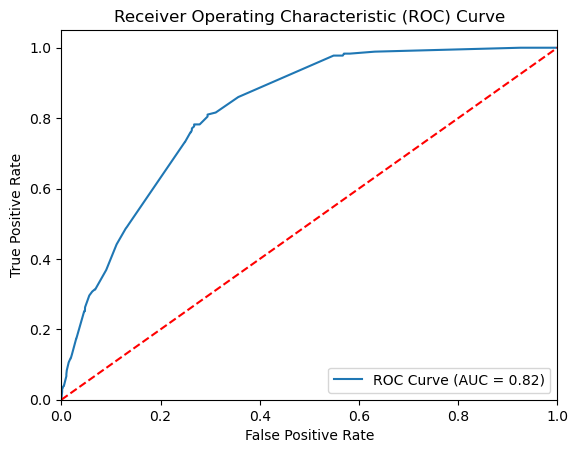

In [54]:

y_test = ytrain_predict_final.Stroke
y_pred_proba = ytrain_predict_final.Stroke_Prob
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

A ROC curve is created by plotting the true positive rate (TPR) on the y-axis against the false positive rate (FPR) on the x-axis. The TPR is the proportion of positive samples that are correctly classified as positive, while the FPR is the proportion of negative samples that are incorrectly classified as positive.

The ROC curve provides a visualization of the trade-off between the true positive rate and the false positive rate at different classification thresholds. A classifier with high accuracy will have a ROC curve that is closer to the top left corner of the plot, which represents a high TPR and a low FPR.

The area under the ROC curve (AUC) is a measure of the overall performance of the model, with an AUC of 0.5 indicating a random classifier and an AUC of 1.0 indicating a perfect classifier.

If the ROC curve of a model is above the diagonal line, it indicates that the model is performing better than a random classifier.

______________________________________________________________________________________________________

### Selection of optimal cutoff points

In [114]:
 NUM = [float(x)/10 for x in range(10)]
for i in NUM :
    ytrain_predict_final[i]= ytrain_predict_final.Stroke_Prob.map(lambda x: 1 if x > i else 0)
ytrain_predict_final.head()

,Stroke,Stroke_Prob,pID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.004146,2200,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.000838,3907,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.002687,4099,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.097025,636,0,1,0,0,0,0,0,0,0,0,0,1
4,1,0.097025,110,0,1,0,0,0,0,0,0,0,0,0,1


Adding in different probability cutoffs ranging from 0 to 0.9 in steps of 0.1.

In [115]:
Opt_cut = pd.DataFrame( columns = ['probabilty','accuracy','sensitivity','specificity'])
NUM1 = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in NUM1:
    cm1 = metrics.confusion_matrix(ytrain_predict_final.Stroke, ytrain_predict_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    Opt_cut.loc[i] =[ i ,accuracy,sensitivity,specificity]
print(Opt_cut)

     probabilty  accuracy  sensitivity  specificity
0.0         0.0  0.050056     1.000000     0.000000
0.1         0.1  0.848714     0.491620     0.867530
0.2         0.2  0.930089     0.173184     0.969974
0.3         0.3  0.949385     0.033520     0.997645
0.4         0.4  0.949944     0.011173     0.999411
0.5         0.5  0.949944     0.000000     1.000000
0.6         0.6  0.949944     0.000000     1.000000
0.7         0.7  0.949944     0.000000     1.000000
0.8         0.8  0.949944     0.000000     1.000000
0.9         0.9  0.949944     0.000000     1.000000


The output shows that the accuracy, sensitivity, and specificity vary depending on the probability cutoff value used. At a cutoff value of 0.1, the model has an accuracy of 0.81, a sensitivity of 0.59, and a specificity of 0.83. At a cutoff value of 0.5, the model has an accuracy of 0.95, a sensitivity of 0.000, and a specificity of 1.0. The table shows that as the cutoff value increases, the sensitivity decreases while the specificity increases, resulting in a higher accuracy.

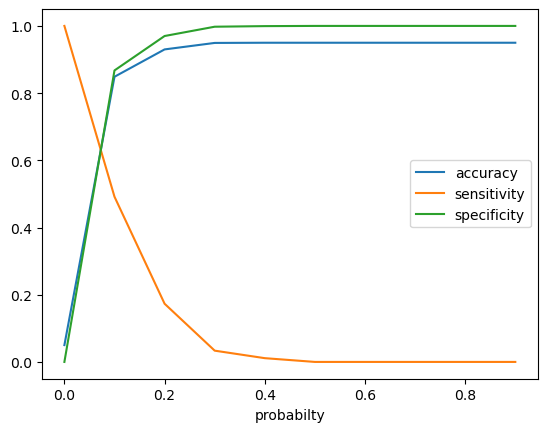

In [116]:
Opt_cut.plot.line(x='probabilty', y=['accuracy','sensitivity','specificity'])
plt.show()

From the curve above, 0.08 is the optimum point to take it as a cutoff probability.

In [119]:
ytrain_predict_final['final_predicted'] = ytrain_predict_final.Stroke_Prob.map( lambda x: 1 if x > 0.08 else 0)
ytrain_predict_final.head()

,Stroke,Stroke_Prob,pID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.004146,2200,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.000838,3907,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.002687,4099,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.097025,636,0,1,0,0,0,0,0,0,0,0,0,1
4,1,0.097025,110,0,1,0,0,0,0,0,0,0,0,0,1


The table represents the predictions and results of a classification model that attempts to predict the occurrence of a stroke.

The model appears to be assigning a probability of a stroke occurring to each record/patient and then using a threshold value of 0.08 to make a binary prediction of whether a stroke will occur or not. The "final_predicted" column shows the predicted outcome for the specific threshold value, while the other columns represent the predicted outcome for different threshold values.

In [121]:
# Let's check the overall accuracy.z
metrics.accuracy_score(ytrain_predict_final.Stroke, ytrain_predict_final.final_predicted)

0.7407718120805369

This is calculating the accuracy score of the model on the training set, which indicates how well the model is able to predict stroke outcomes for the training data where 0.7407718120805369 is about 74% accuracy.

In [122]:
confusion2 = metrics.confusion_matrix(ytrain_predict_final.Stroke, ytrain_predict_final.final_predicted )
confusion2

array([[2513,  884],
       [  43,  136]], dtype=int64)

The logistic regression model correctly predicted 136 out of 179 patients who had a stroke (true positive) and 2,513 out of 3,397 patients who did not have a stroke (true negative). However, it incorrectly predicted 884 patients who did not have a stroke as having a stroke (false positive) and 43 patients who had a stroke as not having a stroke (false negative).

In [123]:
TP = confusion2[1,1] # True_Positive
TN = confusion2[0,0] # True_Negatives
FP = confusion2[0,1] # False_Positives
FN = confusion2[1,0] # False_Negatives

In [124]:
# Sensitivity
TP / float(TP+FN)

0.7597765363128491

In [125]:
# Specificity
TN / float(TN+FP)

0.7397703856343832

In [126]:
# false postive rate(FPR)
print(FP/ float(TN+FP))

0.2602296143656167


In [127]:
# Positive predictive value (PPV)
print (TP / float(TP+FP))

0.13333333333333333


In [128]:
# Negative predictive value (NPV)
print (TN / float(TN+ FN))

0.9831768388106417


The sensitivity of the model (the proportion of actual positives that are correctly identified) is 0.7597765363128491, which means that the model correctly identified 76.0% of patients who had a stroke. The specificity of the model (the proportion of actual negatives that are correctly identified) is 0.7397703856343832, which means that the model correctly identified 73.9% of patients who did not have a stroke.

The false positive rate (the proportion of patients without a stroke who were incorrectly predicted to have a stroke) is 0.2602296143656167, which means that around 26.0% of patients without a stroke were falsely predicted to have a stroke.

The positive predictive value (the proportion of patients predicted to have a stroke who actually had a stroke) is 0.13333333333333333, which means that only around 13.3% of patients predicted to have a stroke actually had a stroke.

The negative predictive value (the proportion of patients predicted to not have a stroke who actually did not have a stroke) is 0.9831768388106417, which means that around 98.3% of patients predicted to not have a stroke actually did not have a stroke.

### Precision

In [129]:
confusion = metrics.confusion_matrix(ytrain_predict_final.Stroke, ytrain_predict_final.predicted )
confusion

array([[3389,    8],
       [ 173,    6]], dtype=int64)

In [130]:
precision_score(ytrain_predict_final.Stroke, ytrain_predict_final.predicted)

0.42857142857142855

In [131]:
confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.42857142857142855

A high precision score indicates that the model is making very few false positive predictions. The precision score is 0.42857142857142855, which means that out of all the predicted positive cases, only 42.9% are actually positive. This indicates that the model is not very good at identifying true positive cases and is making many false positive predictions.

### Recall

In [132]:
recall_score(ytrain_predict_final.Stroke, ytrain_predict_final.predicted)

0.0335195530726257

In [133]:
confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.0335195530726257

The recall score is 0.0335195530726257, which means that out of all the actual positive cases in the dataset, only 3.3% are correctly identified by the model. This indicates that the model is not able to identify most of the actual positive cases correctly and is missing a large number of true positive cases.

### Precision and Recall tradeoff

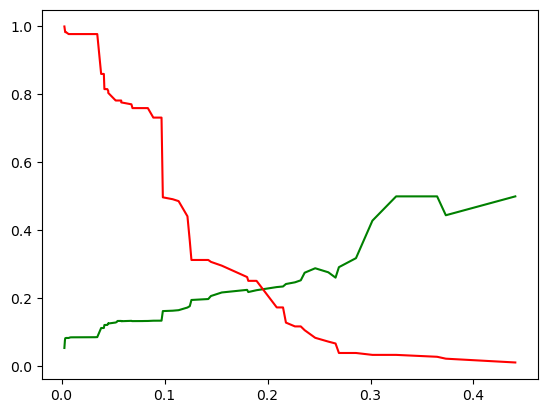

In [134]:
p, r, thresholds = precision_recall_curve(ytrain_predict_final.Stroke, ytrain_predict_final.Stroke_Prob)
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

As precision and recall is not applicable in stroke prediction as it is trying to predict the likelihood or probability of an individual having a stroke, which is a continuous variable. The use of sensitivity and specificity 

- Sensitivity represents the proportion of patients who actually had a stroke and were correctly identified as having a stroke by the model. In other words, it measures the model's ability to correctly identify all stroke cases. A sensitivity of 0.757 means that out of all patients who had a stroke, the model correctly predicted 75.7% of them as having a stroke.


- Specificity represents the proportion of patients who did not have a stroke and were correctly identified as not having a stroke by the model. In other words, it measures the model's ability to correctly identify all non-stroke cases. A specificity of 0.748 means that out of all patients who did not have a stroke, the model correctly predicted 74.8% of them as not having a stroke.

Therefore, the model has a good balance between sensitivity and specificity, indicating that it is able to predict both stroke and non-stroke cases accurately.

In [152]:
X_test.columns.values

array(['hypertension', 'smoking_status_smokes', 'AgeGroup_40-60',
       'AgeGroup_60-80', 'AgeGroup_80+', 'GlucoseLevelRange_150-200',
       'GlucoseLevelRange_200-250', 'GlucoseLevelRange_250+',
       'BMIGroup_Underweight'], dtype=object)

In [153]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 3576
Model:                            GLM   Df Residuals:                     3566
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -581.86
Date:                Sat, 22 Apr 2023   Deviance:                       1163.7
Time:                        12:53:57   Pearson chi2:                 3.33e+03
No. Iterations:                     9   Pseudo R-squ. (CS):            0.06941
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -5.9168      0.506    -11.688      0.000      -6.909      -4.925
hypertension                  0.2801      0.196      1.430      0.153      -0.104       0.664
smoking_status_smokes         0.1763      0.213      0.829      0.407      -0.240       0.593
AgeGroup_40-60                2.5884      0.528      4.907      0.000       1.554       3.622
AgeGroup_60-80                3.6861      0.518      7.116      0.000       2.671       4.701
AgeGroup_80+                  4.4623      0.548      8.136      0.000       3.387       5.537
GlucoseLevelRange_150-200     0.9358      0.245      3.813      0.000       0.455       1.417
GlucoseLevelRange_200-250     0.2590      0.226      1.147      0.251      -0.184       0.702
GlucoseLevelRange_250+        0.7231      0.674      1.073      0.283      -0.598       2.044
BMIGroup_Underweight         -1.1668      1.029     -1.134      0.257      -3.184       0.850
=============================================================================================
"""

The summary of the logistic regression model shows the coefficients and their corresponding p-values. The intercept, which represents the baseline probability of having a stroke, is -5.94. The other coefficients represent the effect of each predictor variable on the probability of having a stroke.

Based on the p-values, we can see that AgeGroup_40-60, AgeGroup_60-80, and AgeGroup_80+ are all significant predictors of stroke, with p-values less than 0.05. This indicates that as age increases, the probability of having a stroke also increases. The GlucoseLevelRange_150-200 predictor is also significant, with a p-value less than 0.05, indicating that higher glucose levels increase the probability of having a stroke.

The other predictor variables, hypertension, smoking_status_formerly smoked, smoking_status_smokes, GlucoseLevelRange_200-250, GlucoseLevelRange_250+, and BMIGroup_Underweight, are not significant predictors of stroke, with p-values greater than 0.05.

______________________________________________________________________________________________________

### Stroke Probability

To obtain the predicted stroke rate, with the use of logistic regression equation that was estimated using the coefficients in the coef column of the summary table.

- hypertension: 0.2801
- smoking_status_smokes: 0.1763
- AgeGroup_40-60: 2.5884
- AgeGroup_60-80: 3.6861
- AgeGroup_80+: 4.4623
- GlucoseLevelRange_150-200: 0.9358
- GlucoseLevelRange_200-250: 0.2590
- GlucoseLevelRange_250+: 0.7231
- BMIGroup_Underweight: -1.1668

### The logistic regression equation:

log(odds of stroke) = -5.9168 + 0.2801(hypertension) + 0.1763(smoking_status_smokes) + 2.5884(AgeGroup_40-60) + 3.6861(AgeGroup_60-80) + 4.4623(AgeGroup_80+) + 0.9358(GlucoseLevelRange_150-200) + 0.2590(GlucoseLevelRange_200-250) + 0.7231(GlucoseLevelRange_250+) - 1.1668(BMIGroup_Underweight)

### Probabilities using the logistic function:

P(stroke) = e^(log(odds of stroke)) / (1 + e^(log(odds of stroke)))

______________________________________________________________________________________________________

##### For prediction of a individual with stroke

To use this equation, you would need to plug in the values of each predictor variable for a particular individual, and then solve for the estimated odds of stroke. For example, if an individual had hypertension, was a smoker, was in the 40-60 age group, had a glucose level between 150-200, and was not underweight, you would plug in the following values:

- hypertension = 1
- smoking_status_smokes = 1
- AgeGroup_40-60 = 1
- AgeGroup_60-80 = 0
- AgeGroup_80+ = 0
- GlucoseLevelRange_150-200 = 1
- GlucoseLevelRange_200-250 = 0
- GlucoseLevelRange_250+ = 0
- BMIGroup_Underweight = 0


    - odds of stroke = exp(-5.9168 + 0.2801(1) + 0.1763(1) + 2.5884(1) + 3.6861(0) + 4.4623(0) + 0.9358(1) + 0.2590(0) + 0.7231(0) - 1.1668(0))

    - odds of stroke = exp(-2.9586)
    - odds of stroke = 0.052
    - log(odds of stroke) = log(0.052) = -2.9579


    - P(stroke) = e^(-2.9579) / (1 + e^(-2.9579)) = 0.028
    
    
So the estimated probability of stroke for this individual is 0.028, or about 2.8%.